In [1]:
# 전처리

import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


  cat truck  bird  deer


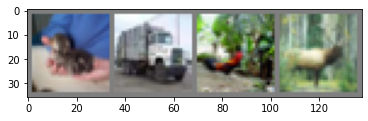

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [87]:
# CNN 정의

import torch.nn as nn
import torch.nn.functional as F


class AddTwoLayerNet(nn.Module):
    def __init__(self):
        super(AddTwoLayerNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, stride = 1, padding = 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3, stride = 1, padding = 1)
        self.conv3 = nn.Conv2d(16, 32, 3, stride = 1, padding = 1)
        self.conv4 = nn.Conv2d(32, 64, 3, stride = 1, padding = 1)
        self.fc1 = nn.Linear(64 * 4 * 4, 240)
        self.fc2 = nn.Linear(240, 84)
        self.fc3 = nn.Linear(84, 10)
        self.classifier = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.conv4(x)))
        features = x
        x = x.view(-1, 64 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x, features


net = AddTwoLayerNet()

In [88]:
# Optimizer Criterion
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [89]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)[0]
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.301
[1,  4000] loss: 2.151
[1,  6000] loss: 1.979
[1,  8000] loss: 1.859
[1, 10000] loss: 1.693
[1, 12000] loss: 1.610
[2,  2000] loss: 1.537
[2,  4000] loss: 1.497
[2,  6000] loss: 1.462
[2,  8000] loss: 1.427
[2, 10000] loss: 1.391
[2, 12000] loss: 1.356
Finished Training


torch.Size([6, 32, 32])
torch.Size([16, 16, 16])


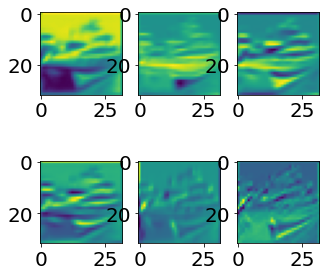

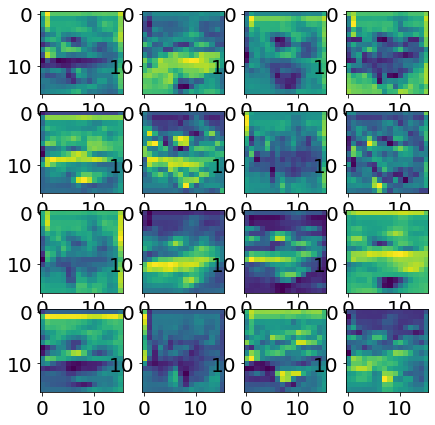

In [90]:
# Intermediate Feature Space

activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    
    return hook

net.conv1.register_forward_hook(get_activation('conv1'))
net.conv2.register_forward_hook(get_activation('conv2'))

data, _ = testset[1]
data.unsqueeze_(0)
output = net(data.to())[0]


act = activation['conv1'].squeeze()
act2 = activation['conv2'].squeeze()

print(act.shape)
print(act2.shape)

row, col = 2, 3

fig, axarr = plt.subplots(row, col, figsize=(5, 5))

for i in range(row):
    for j in range(col):
        axarr[i][j].imshow(act[i*col+j].cpu())
        
row, col = 4, 4
        
fig2, axarr2 = plt.subplots(row, col, figsize=(7, 7))
for i in range(row):
    for j in range(col):
        axarr2[i][j].imshow(act2[i*col+j].cpu())

torch.Size([1, 128, 4, 4])


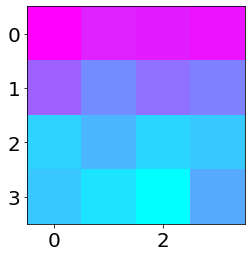

In [35]:
# CAM

image, label = testset[1]
batch_img = image[None, :, :, :].to()

x, map = net(batch_img)
print(map.shape)

class_weight = net.classifier.weight[int(label)].unsqueeze(-1).unsqueeze(-1)
cam_ = torch.squeeze(map) * class_weight

cam = torch.sum(cam_, axis=0)
cam = cam.detach().cpu().numpy()

plt.imshow(cam, cmap="cool", interpolation="nearest")
plt.show()

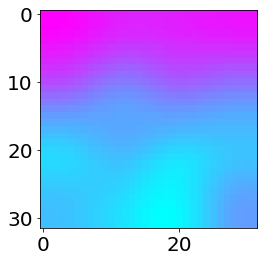

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


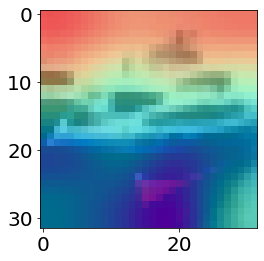

In [36]:
import cv2

resize_cam = cv2.resize(cam, dsize=(32, 32), interpolation=cv2.INTER_CUBIC)
plt.imshow(resize_cam, cmap="cool", interpolation="nearest")
plt.show()

imshow(image)

origin = image.detach().numpy()

plt.imshow(np.rollaxis(origin, 0, 3))
plt.imshow(resize_cam, alpha=0.6, cmap="rainbow")
plt.show()

In [91]:
# feature space와 그에 대응하는 label space 추출

feature_space = torch.Tensor()
label_space = torch.Tensor()
for i in range(0, 1000):
  image, label = testset[i]
  batch_img = image[None, :, :, :].to()
  outputs, map = net(batch_img)
  predicted = torch.max(outputs.data, 1)[1]
  label_space = torch.cat([label_space, predicted.unsqueeze(0)], dim=0)
  map = torch.flatten(map, 1)
  feature_space = torch.cat([feature_space, map], dim=0)

feature_space = feature_space.detach().cpu().numpy()
label_space = label_space.detach().cpu().numpy()

In [92]:
# feature space를 가지고 dataframe 생성

import pandas as pd
import seaborn as sn

df = pd.DataFrame(feature_space)
df

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0.281887,0.321898,0.143670,0.000000,0.192256,0.318080,0.000000,2.027749,0.000000,0.801429,...,1.716628,0.724827,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.363071,0.000000,0.000000,1.159286,0.000000,0.000000,0.167105,0.073332,0.011825,0.022503,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,1.577798,0.000000,0.150206,0.492968,1.777256,0.891800,0.867603,...,0.000000,0.884423,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.524367,0.128369,0.000000,1.133338,0.000000,0.000000,0.000000,0.775604,1.036062,0.161324,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.410407,0.209701,0.127917,0.000000,0.494455,0.567985,0.000000,0.149396,0.086758,0.000000,...,0.378187,0.022783,0.302647,0.709566,0.082412,0.482873,0.574595,0.000000,0.636453,0.499630
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.000000,1.872019,0.691836,0.098446,1.003220,0.000000,1.488726,1.461972,0.000000,0.000000,...,0.000000,0.303189,0.093355,1.049621,0.373814,0.057125,0.753885,0.241589,0.499809,0.404658
996,0.000000,0.000000,0.000000,1.478673,0.000000,1.395968,1.092639,0.000000,1.010746,0.376923,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.577034,0.000000,0.000000,0.000000,0.322983
997,0.000000,0.000000,3.490670,0.971022,0.000000,0.136398,2.023904,2.032599,0.000000,0.000000,...,0.000000,0.363974,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.015233
998,0.000000,2.497154,0.000000,0.802382,0.000000,0.890231,0.000000,0.795330,0.000000,0.567193,...,0.000000,0.285468,0.811496,0.423474,0.512691,0.074273,0.192852,0.000000,0.000000,0.113046


In [93]:
# feature space를 PCA에 적용하기 전 StandardScaler로 데이터 Normalization 과정

from sklearn.preprocessing import StandardScaler

scalar = StandardScaler()
result = scalar.fit_transform(df)
data_scaled = pd.DataFrame(result)
data_scaled.describe()

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
count,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,...,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03,1.000000e+03
mean,-2.670288e-08,1.788139e-08,-7.772446e-08,8.404255e-09,-2.849102e-08,5.245209e-08,2.121925e-08,-4.041195e-08,3.021956e-08,-2.747774e-08,...,-3.230572e-08,-5.155802e-08,3.665686e-08,1.568794e-07,-1.615286e-08,-1.007318e-08,1.132488e-09,-1.180172e-08,-1.301765e-07,1.800060e-08
std,1.000501e+00,1.000503e+00,1.000502e+00,1.000500e+00,1.000499e+00,1.000501e+00,1.000499e+00,1.000500e+00,1.000499e+00,1.000499e+00,...,1.000501e+00,1.000500e+00,1.000502e+00,1.000499e+00,1.000500e+00,1.000500e+00,1.000498e+00,1.000503e+00,1.000497e+00,1.000504e+00
min,-5.729808e-01,-5.299008e-01,-5.372884e-01,-1.081555e+00,-6.633860e-01,-7.272341e-01,-6.471219e-01,-7.936915e-01,-6.774018e-01,-7.638758e-01,...,-6.222073e-01,-7.361182e-01,-6.181088e-01,-6.423041e-01,-6.401965e-01,-7.311280e-01,-5.491800e-01,-5.426607e-01,-5.240911e-01,-5.866414e-01
25%,-5.729808e-01,-5.299008e-01,-5.372884e-01,-9.198112e-01,-6.633860e-01,-7.272341e-01,-6.471219e-01,-7.936915e-01,-6.774018e-01,-7.638758e-01,...,-6.222073e-01,-7.361182e-01,-6.181088e-01,-6.423041e-01,-6.401965e-01,-7.311280e-01,-5.491800e-01,-5.426607e-01,-5.240911e-01,-5.866414e-01
50%,-5.729808e-01,-5.299008e-01,-5.372884e-01,-1.735125e-01,-5.101454e-01,-4.294960e-01,-5.616511e-01,-3.378662e-01,-4.230951e-01,-3.620925e-01,...,-6.222073e-01,-5.191442e-01,-6.181088e-01,-6.423041e-01,-6.401965e-01,-5.011471e-01,-5.491800e-01,-5.426607e-01,-5.240911e-01,-5.866414e-01
75%,2.585803e-01,1.286921e-01,1.570914e-01,6.336284e-01,3.047851e-01,4.377576e-01,4.075327e-01,4.540440e-01,3.743303e-01,4.614891e-01,...,3.793513e-01,5.259123e-01,3.461179e-01,4.621454e-01,4.638151e-01,5.267381e-01,1.671642e-01,1.680300e-01,1.705598e-01,3.545754e-01
max,6.179800e+00,5.933093e+00,5.257249e+00,5.746082e+00,5.386806e+00,6.062349e+00,9.799150e+00,6.536914e+00,7.518740e+00,8.469616e+00,...,7.298728e+00,5.462752e+00,5.331739e+00,6.272017e+00,5.332795e+00,5.429269e+00,5.393742e+00,5.284142e+00,6.013268e+00,9.156661e+00


In [94]:
# feature space의 값을 PCA를 통해 3차원으로 차원 축소

from sklearn.decomposition import PCA

pca = PCA(n_components=3)
result = pca.fit_transform(data_scaled)

result = pd.DataFrame(result, columns=["x", "y", "z"])
result

,x,y,z
0,6.652972,2.472015,11.612828
1,8.515130,-7.415242,-10.242690
2,7.220186,-5.133395,-2.405131
3,8.699593,-3.744770,-5.463942
4,-7.807187,-3.338454,7.321655
...,...,...,...
995,-4.891039,6.502747,2.812021
996,5.907452,2.700970,-4.645969
997,13.571323,-8.237453,-0.140435
998,-2.530531,-3.003715,5.317836


In [95]:
# 각 축소된 값에 대응되는 label 연결하기

target = pd.DataFrame(label_space, columns=['label'])
target['label'] = target['label'].apply(lambda x: x)
merged = pd.concat([result, target], axis=1)
merged

,x,y,z,label
0,6.652972,2.472015,11.612828,5.0
1,8.515130,-7.415242,-10.242690,1.0
2,7.220186,-5.133395,-2.405131,8.0
3,8.699593,-3.744770,-5.463942,0.0
4,-7.807187,-3.338454,7.321655,3.0
...,...,...,...,...
995,-4.891039,6.502747,2.812021,2.0
996,5.907452,2.700970,-4.645969,8.0
997,13.571323,-8.237453,-0.140435,1.0
998,-2.530531,-3.003715,5.317836,5.0


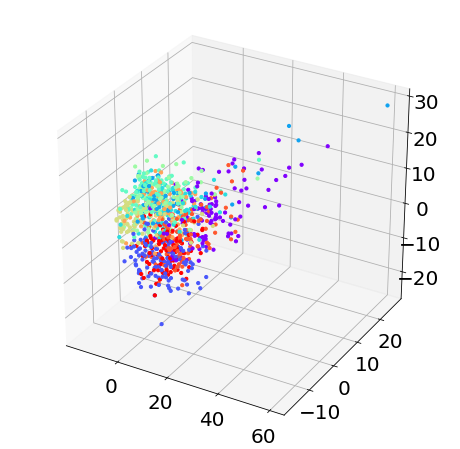

In [96]:
# label로 구별되는 feature space 표출

import matplotlib.pyplot as plt
import matplotlib as mlp
import seaborn as sns

%matplotlib inline

mlp.rcParams['font.size'] = 20
mlp.rcParams['font.family'] = 'Nanum Gothic'

# 3D 출력
fig = plt.figure(figsize=(8, 8))
ax = fig.gca(projection='3d')

ax.scatter(merged['x'], merged['y'], merged['z'], c= merged.label, s=10, cmap='rainbow', alpha=1)


# 2D 출력
# plt.figure(figsize=(16, 9))
# sns.set_palette(sns.color_palette("muted"))

# sns.scatterplot(merged['x'], 
#                      merged['y'],
#                      hue=merged['label'], 
#                      s=100,
#                      palette=sns.color_palette('muted', n_colors=10),
#                     )
plt.show()

In [97]:
# kmeans 과정

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import random

random_Seed = random.randrange(0, 16546)

clust_model = KMeans(n_clusters = 10, init = 'k-means++', max_iter=300, random_state=random_Seed)
clust_model.fit(merged)
centers = clust_model.cluster_centers_
pred = clust_model.predict(merged)


In [98]:
# 축소된 값에 kmeans 과정을 통해 얻은 clust 연결하기

kmeans_df = merged.copy()
kmeans_df['clust'] = pred

#kmeans_df.head()
kmeans_df.groupby(["label", "clust"]).size()

label  clust
0.0    1        12
       2        16
       3        32
       5         8
       6        17
                ..
9.0    2         7
       5         8
       7         1
       8         4
       9        20
Length: 78, dtype: int64

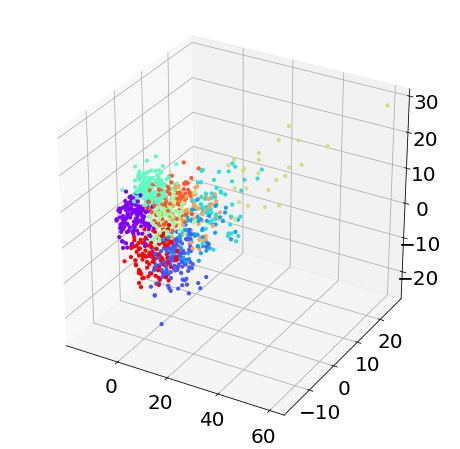

In [99]:
# kmeans를 통해 나타난 집단을 표출

# 3D 출력
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

X = kmeans_df

ax.scatter(X.iloc[:,0]
           , X.iloc[:,1]
           , X.iloc[:,2]
           , c = X.clust
           , s = 10
           , cmap = "rainbow"
           , alpha = 1
           )

#ax.scatter(centers[:,0], centers[:,1], centers[:,2], c='black', s=200, marker='*')


# 2D 출력
# plt.figure(figsize=(16, 9))
# sns.set_palette(sns.color_palette("muted"))

# sns.scatterplot(clust_df['x'], 
#                      clust_df['y'],
#                      hue=clust_df['clust'], 
#                      s=100,
#                      palette=sns.color_palette('muted', n_colors=10),
#                     )





plt.show()

In [100]:
# gmm 과정

gmm = GaussianMixture(n_components=10, random_state=random_Seed)
gmm_labels = gmm.fit_predict(merged)

gmm_df = merged.copy()
gmm_df["gmm_cluster"] = gmm_labels

#gmm_df.head()
gmm_df.groupby(["label", "gmm_cluster"]).size()

label  gmm_cluster
0.0    9              117
1.0    7              137
2.0    1               39
       2                8
       3                3
       5                3
       6               16
3.0    1               33
       2                4
       3               15
       6               32
4.0    1               38
       2                4
       3                6
       6               33
       8               26
5.0    1               24
       2                3
       3                4
       6               46
       8               29
6.0    1                5
       2                1
       3               18
       6               16
       8               63
7.0    1               30
       3               27
       6               21
       8                6
8.0    0               90
       2                4
       4               10
       6                1
9.0    0               82
       3                1
       4                5
dtype: int64

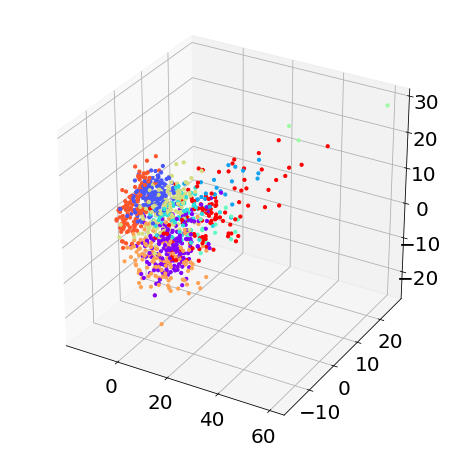

In [101]:
# gmm를 통해 나타난 집단을 표출

# 3D 출력
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

X = gmm_df

ax.scatter(X.iloc[:,0]
           , X.iloc[:,1]
           , X.iloc[:,2]
           , c = X.gmm_cluster
           , s = 10
           , cmap = "rainbow"
           , alpha = 1
           )


# 2D 출력
# plt.figure(figsize=(16, 9))
# sns.set_palette(sns.color_palette("muted"))

# sns.scatterplot(merged['x'], 
#                      merged['y'],
#                      hue=merged['gmm_cluster'], 
#                      s=100,
#                      palette=sns.color_palette('muted', n_colors=10),
#                     )



plt.show()